In [1]:
%load_ext Cython

import matplotlib.pyplot as plt
import multiprocessing as mp
import numpy as np
import pandas as pd
import pykonal
import seispy

EARTH_RADIUS = 6371.
DTYPE_REAL = np.float64

In [56]:
%%cython

import numpy as np
import scipy.optimize
cimport numpy as np


ctypedef np.float64_t _REAL_t

EARTH_RADIUS = 6371.
DTYPE_REAL = np.float64

def geo2sph(arr):
    """
    Map Geographical coordinates to spherical coordinates.
    """
    geo = np.array(arr, dtype=DTYPE_REAL)
    sph = np.empty_like(geo)
    sph[..., 0] = EARTH_RADIUS - geo[..., 2]
    sph[..., 1] = np.pi / 2 - np.radians(geo[..., 0])
    sph[..., 2] = np.radians(geo[..., 1])
    return (sph)


def sph2geo(arr):
    """
    Map spherical coordinates to geographic coordinates.
    """
    sph = np.array(arr, dtype=DTYPE_REAL)
    geo = np.empty_like(sph)
    geo[..., 0] = np.degrees(np.pi / 2 - sph[..., 1])
    geo[..., 1] = np.degrees(sph[..., 2])
    geo[..., 2] = EARTH_RADIUS - sph[..., 0]
    return (geo)


cdef class EQLocator(object):
    cdef dict _arrivals
    cdef dict _tt_calculators
    cdef _REAL_t[:,:,:,:] _grid
    cdef tuple _bounds
    cdef dict _priors
    
    def __init__(self, arrivals, tt_calculators, grid):
        self.arrivals = {key: arrivals[key] for key in tt_calculators}
        self.tt_calculators = tt_calculators
        self.grid = grid
    
    @property
    def arrivals(self):
        return (self._arrivals)
    
    @arrivals.setter
    def arrivals(self, value):
        self._arrivals = value
    
    @property
    def grid(self):
        return (np.asarray(self._grid))
    
    @grid.setter
    def grid(self, value):
        self._grid = value
        
    @property
    def tt_calculators(self):
        return (self._tt_calculators)
    
    @tt_calculators.setter
    def tt_calculators(self, value):
        self._tt_calculators = value
        
    cpdef initial_guess(self):
        values = [self.arrivals[key]-self.tt_calculators[key].values for key in self.tt_calculators]
        values = np.ma.masked_invalid(np.stack(values))
        std = values.std(axis=0)
        arg_min = np.argmin(std)
        idx_min = np.unravel_index(arg_min, std.shape)
        geo = sph2geo(self.grid[idx_min])
        time = values.mean(axis=0)[idx_min]
        return (np.array([*geo, time]))

    cpdef cost(self, _REAL_t[:] hypocenter):
        cdef tuple key
        cdef _REAL_t csum = 0
        cdef _REAL_t lat, lon, depth, time
        lat = hypocenter[0]
        lon = hypocenter[1]
        depth = hypocenter[2]
        time = hypocenter[3]
        sph_coords = geo2sph((lat, lon, depth))
        if not np.all(sph_coords > np.asarray(self.grid).min(axis=(0,1,2))) or not np.all(sph_coords < np.asarray(self.grid).max(axis=(0,1,2))):
            return (np.inf)
        for key in self.arrivals:
            tt_calculator = self.tt_calculators[key].value
            csum += np.square(self.arrivals[key]-(time+tt_calculator(sph_coords)))
        return (np.sqrt(csum/len(self.arrivals)))
    
    cpdef locate(self):
        cdef _REAL_t[4] h0
        h0 = self.initial_guess()
        soln = scipy.optimize.differential_evolution(
            self.cost,
            ((h0[0]-0.1, h0[0]+0.1), (h0[1]-0.1, h0[1]+0.1), (0, 30), (h0[3]-5, h0[3]+5))
        )
        return (soln.x)

In [3]:
def init_farfield(vmodel):
    """
    Initialize the far-field EikonalSolver with the given velocity model.
    """
    far_field = pykonal.EikonalSolver(coord_sys='spherical')
    far_field.vv.min_coords = vmodel.min_coords
    far_field.vv.node_intervals = vmodel.node_intervals
    far_field.vv.npts = vmodel.npts
    far_field.vv.values = vmodel.values
    return (far_field)

def init_nearfield(far_field, origin):
    """
    Initialize the near-field EikonalSolver.
    :param origin: Station location in spherical coordinates.
    :type origin: (float, float, float)
    :return: Near-field EikonalSolver
    :rtype: pykonal.EikonalSolver
    """
    refinement_factor = 10
    drho = far_field.vv.node_intervals[0] / refinement_factor
    near_field = pykonal.EikonalSolver(coord_sys="spherical")
    near_field.vv.min_coords = drho, 0, 0
    near_field.vv.node_intervals = drho, np.pi / 20, np.pi / 20
    near_field.vv.npts = 100, 21, 40
    nodes = near_field.vv.transform_coordinates("spherical", origin)
    near_field.vv.values = far_field.vv.resample(nodes.reshape(-1, 3)).reshape(near_field.vv.npts)
    for it in range(near_field.tt.npts[1]):
        for ip in range(near_field.tt.npts[2]):
            idx = (0, it, ip)
            vv = near_field.vv.values[idx]
            if not np.isnan(vv):
                near_field.tt.values[idx] = near_field.tt.nodes[idx + (0,)] / vv
                near_field.is_far[idx] = False
                near_field.close.push(*idx)
    return (near_field)

def compute_traveltime_lookup_table(origin, vmodel):
    far_field = init_farfield(vmodel)
    near_field = init_nearfield(far_field, origin)
    near_field.solve()

    # Compute the origin of the far-field coordinate system w.r.t. the
    # near-field coordinate system.
    origin = (origin[0], np.pi - origin[1], (origin[2] + np.pi) % (2*np.pi))
    nodes = far_field.tt.transform_coordinates("spherical", origin)    
    # Determine which nodes of the far-field grid fall inside the
    # bounds of the near-field grid.
    nonzero_idx = np.nonzero(
         (nodes[...,0] >= near_field.vv.min_coords[0])
        &(nodes[...,0] <= near_field.vv.max_coords[0])
        &(nodes[...,1] >= near_field.vv.min_coords[1])
        &(nodes[...,1] <= near_field.vv.max_coords[1])
        &(nodes[...,2] >= near_field.vv.min_coords[2])
        &(nodes[...,2] <= near_field.vv.max_coords[2])
    )
    # Interpolate traveltimes from the near-field grid onto the 
    # far-field grid.
    tt = near_field.tt.resample(nodes[nonzero_idx])
    # Determine which of the interpolated values are NaNs.
    nan_idx = np.isnan(tt)
    # Drop the indices for NaNs.
    nonzero_idx = tuple(nonzero_idx[i][~nan_idx] for i in range(3))
    # Update the far-field traveltime grid with interpolated values.
    far_field.tt.values[nonzero_idx] = near_field.tt.resample(nodes[nonzero_idx])
    # Update the state variables for tracking the narrow band.
    far_field.is_far[nonzero_idx] = False
    nonzero_idx = np.stack(nonzero_idx)
    for idx in range(nonzero_idx.shape[1]):
        idx = tuple(nonzero_idx[:,idx])
        far_field.close.push(*idx)
    far_field.solve()
    return (far_field)

# Load a test data set

In [4]:
db = seispy.pandas.catalog.Catalog(
    "/home/malcolmw/google_drive/malcolm.white@usc.edu/data/events/malcolmw/SJFZ_catalog_2008-2016.h5",
    fmt="hdf5"
)

gc_events_dataframe = pd.read_csv(
    "/home/malcolmw/scratch/events.grow", 
    delim_whitespace=True, 
    header=None,
    names=["year", "month", "day", "hour", "minute", "second", "lat", "lon", "depth", "null_0", "null_1", "null_2", "null_3", "event_id"]
)
gc_events_dataframe["time"] = seispy.pandas.time.to_epoch(seispy.pandas.time.ymd_to_dt(gc_events_dataframe))*1e-9
gc_events_dataframe["event_id"] -= int(2e9)
db["origin"] = db["origin"][["orid", "evid"]].merge(
    gc_events_dataframe[["lat", "lon", "depth", "time", "event_id"]],
    left_on="evid",
    right_on="event_id"
).drop(columns=["evid"])

stations_dataframe = db["site"][
    ["sta", "lat", "lon", "elev"]
].drop_duplicates(
    "sta"
).merge(
    db["snetsta"][
        ["snet", "sta"]
    ].drop_duplicates(
        "sta"
    ),
    on="sta"
)
stations_dataframe["station_id"] = stations_dataframe["snet"] + "." + stations_dataframe["sta"]

arrivals_dataframe = db["arrival"][
    ["sta", "time", "arid"]
].merge(
    db["assoc"][
        ["arid", "orid", "phase"]
    ],
    on="arid"
).merge(
    stations_dataframe[["sta", "station_id"]],
    on="sta"
).merge(
    db["origin"][["orid", "event_id"]],
    on="orid"
).sort_values(
    "event_id"
).set_index(
    "event_id"
)[
    ["station_id", "phase", "time", "arid"]
]

stations_dataframe["depth"] = -stations_dataframe["elev"]
stations_dataframe = stations_dataframe[
    ["station_id", "lat", "lon", "depth"]
].set_index(
    "station_id"
)
stations_dataframe = stations_dataframe[
    stations_dataframe.index.isin(arrivals_dataframe["station_id"].unique())
]

# Read and resample the velocity model

In [5]:
with np.load("/home/malcolmw/google_drive/malcolm.white@usc.edu/data/velocity/White_et_al_2019a/White_et_al_2019a.regular.npz") as npz:
    vp = pykonal.field.ScalarField3D(coord_sys="spherical")
    vs = pykonal.field.ScalarField3D(coord_sys="spherical")
    vp.min_coords = vs.min_coords = npz["grid_parameters"][:3]
    vp.node_intervals = vs.node_intervals = npz["grid_parameters"][3:6]
    vp.npts = vs.npts = npz["grid_parameters"][6:] + [1, 0, 0]
    vp.values = np.append(npz["vp"], npz["vp"][[-1]], axis=0)
    vs.values = np.append(npz["vs"], npz["vs"][[-1]], axis=0)
    
# Resample the velocity model (18, 32, 32) --> (64, 128, 128)
rho_min, theta_min, phi_min = vp.min_coords
rho_max, theta_max, phi_max = vp.max_coords
nrho, ntheta, nphi = 64, 128, 128

drho = (rho_max - rho_min) / (nrho - 1)
rho = np.linspace(rho_min, rho_max, nrho)

dtheta = (theta_max - theta_min) / (ntheta - 1)
theta = np.linspace(theta_min, theta_max, ntheta)

dphi = (phi_max - phi_min) / (nphi - 1)
phi = np.linspace(phi_min, phi_max, nphi)

rtp = np.moveaxis(
    np.stack(np.meshgrid(rho, theta, phi, indexing="ij")),
    0, 
    -1
)
vp_new = vp.resample(rtp.reshape(-1, 3)).reshape(rtp.shape[:-1])
vs_new = vs.resample(rtp.reshape(-1, 3)).reshape(rtp.shape[:-1])

vp = pykonal.field.ScalarField3D(coord_sys="spherical")
vs = pykonal.field.ScalarField3D(coord_sys="spherical")
vp.min_coords = vs.min_coords = rho_min, theta_min, phi_min
vp.node_intervals = vs.node_intervals = drho, dtheta, dphi
vp.npts = vs.npts = nrho, ntheta, nphi
vp.values = vp_new
vs.values = vs_new

# Subset the events dataset

In [6]:
# Only events inside the focus region of White et al. 2019 with 32 or more arrivals
df = arrivals_dataframe.reset_index().groupby("event_id").count()
arrivals_dataframe = arrivals_dataframe[
     (arrivals_dataframe.index.isin(df[df["station_id"] >= 128].index))
    &(arrivals_dataframe.index.isin(
        db["origin"][seispy.coords.as_geographic(db["origin"][["lat", "lon", "depth"]]).in_rectangle()]["event_id"]
        )
     )
]

# Compute traveltime-lookup tables

In [ ]:
def target(args, vp=vp, vs=vs):
    station_id, coords = args[0], geo2sph(args[1].values)
    print(station_id)
    solver = compute_traveltime_lookup_table(coords, vp)
    solver.tt.savez(f"/home/malcolmw/scratch/traveltimes/{station_id}.P.npz")
    solver = compute_traveltime_lookup_table(coords, vs)
    solver.tt.savez(f"/home/malcolmw/scratch/traveltimes/{station_id}.S.npz")
    
with mp.Pool() as pool:
    pool.map(target, stations_dataframe.iterrows())

# Locate events

In [66]:
def generate_arrivals(arrivals_dataframe):
    for event_id in arrivals_dataframe.index.unique()[:]:
        yield (event_id, arrivals_dataframe.loc[event_id].set_index(["station_id", "phase"]).to_dict()["time"])
    
def target(args, nodes=vp.nodes):
    event_id, arrivals = args
    print(f"Locating event #{event_id}")
    tt_calculators = {
        key: pykonal.field.load(f"/home/malcolmw/scratch/traveltimes/{key[0]}.{key[1]}.npz") for key in arrivals
    }
    locator = EQLocator(
        arrivals=arrivals,
        tt_calculators=tt_calculators,
        grid=nodes
    )
    return (event_id, locator.locate())

In [ ]:
with mp.Pool(4) as pool:
    locations = pool.map(target,  generate_arrivals(arrivals_dataframe))

Locating event #13003981
Locating event #13006516
Locating event #13002746
Locating event #11007171
Locating event #13007050
Locating event #12001692
Locating event #13004220
Locating event #13002761
Locating event #13004457
Locating event #12002113
Locating event #13007776
Locating event #13002817


In [18]:
relocated_events_dataframe = pd.DataFrame([[loc[0], *loc[1]] for loc in locations], columns=["event_id", "lat", "lon", "depth", "time"]).set_index("event_id")

In [19]:
original_events_dataframe = db["origin"][db["origin"]["event_id"].isin(arrivals_dataframe.index.unique())].set_index("event_id")

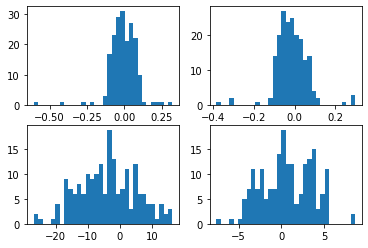

In [20]:
plt.close("all")
fig = plt.figure()
ax00 = fig.add_subplot(2, 2, 1)
ax01 = fig.add_subplot(2, 2, 2)
ax10 = fig.add_subplot(2, 2, 3)
ax11 = fig.add_subplot(2, 2, 4)
for ax, key in ((ax00, "lat"), (ax01, "lon"), (ax10, "depth"), (ax11, "time")):
    ax.hist(original_events_dataframe[key] - relocated_events_dataframe[key], bins=32)

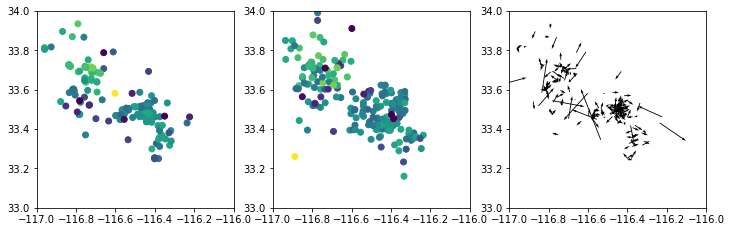

In [38]:
fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(1, 3, 1, aspect=1)
ax2 = fig.add_subplot(1, 3, 2, aspect=1)
ax3 = fig.add_subplot(1, 3, 3, aspect=1)
ax1.scatter(
    original_events_dataframe["lon"], 
    original_events_dataframe["lat"],
    c=original_events_dataframe["depth"],
    vmin=0,
    vmax=25
)
ax2.scatter(
    relocated_events_dataframe["lon"],
    relocated_events_dataframe["lat"],
    c=original_events_dataframe["depth"],
    vmin=0,
    vmax=25
)
ax3.quiver(
    original_events_dataframe["lon"], 
    original_events_dataframe["lat"],
    relocated_events_dataframe["lon"] - original_events_dataframe["lon"],
    relocated_events_dataframe["lat"] - original_events_dataframe["lat"],
)
for ax in (ax1, ax2, ax3):
    ax.set_xlim(-117, -116)
    ax.set_ylim(33, 34)

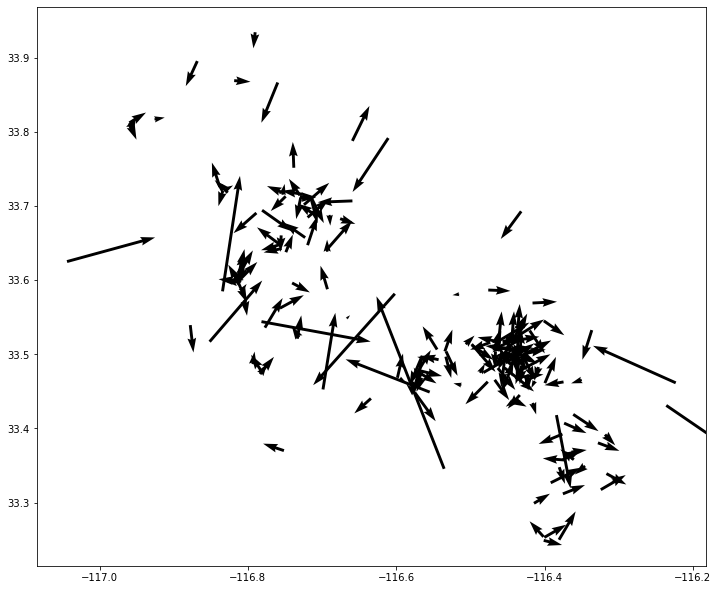

In [39]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, aspect=1)
ax.quiver(
    original_events_dataframe["lon"], 
    original_events_dataframe["lat"],
    relocated_events_dataframe["lon"] - original_events_dataframe["lon"],
    relocated_events_dataframe["lat"] - original_events_dataframe["lat"],
)

In [65]:
for event_id, origin in relocated_events_dataframe.iterrows():
    arrivals = arrivals_dataframe.loc[event_id].set_index(["station_id", "phase"]).to_dict()["time"]
    tt_calculators = {
        key: pykonal.field.load(f"/home/malcolmw/scratch/traveltimes/{key[0]}.{key[1]}.npz") for key in arrivals
    }
    locator = EQLocator(
        arrivals=arrivals,
        tt_calculators=tt_calculators,
        grid=vp.nodes
    )
    print(
        event_id, 
        locator.cost(origin[["lat", "lon", "depth", "time"]].values), 
        locator.cost(original_events_dataframe.loc[event_id, ["lat", "lon", "depth", "time"]].values)
    )

11007171 1.5106311954803262 0.728684680961484
12001692 0.8657670567296245 0.5366721404496898
12002113 3.7048729043583415 0.6328081567265318
12003572 2.4367119160051263 5.907682897263378
12004493 4.678013207022369 0.677609178682739
12004810 1.6594834391933695 0.5464130129913131


KeyboardInterrupt: 